# XGBoost versus multivariate normal distribution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import xgboost
import sklearn.datasets as datasets
import scipy.stats as stats

from hyperopt import hp
from hyperopt import fmin, STATUS_OK, tpe, hp
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import copy

rnd.seed(1)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
n_features = 10
n_samples = 2000
proportion = 0.5

* Create a random sample $X$ of features following a multivariate gaussian distribution:

In [3]:
cov = datasets.make_spd_matrix( n_features )
mean = np.zeros( len(cov) )
mn = stats.multivariate_normal(mean, cov)

In [4]:
X = mn.rvs( n_samples )

* Binary classification using $\chi^2$:

In [5]:
V = np.linalg.inv(cov)
dist = np.array( [np.dot(X[i], np.dot(V,X[i:i+1].T))[0] for i in xrange( len(X) ) ] )

chi2 = stats.chi2( len(cov) )
y = (dist>chi2.isf( proportion ))
print 'Check proportion:', np.sum(y)/float( len(y) )

Check proportion: 0.502


Select negative and positive samples:

In [6]:
X_pos = X[ y ]
X_neg = X[ ~y ]

Sample scatter plot:

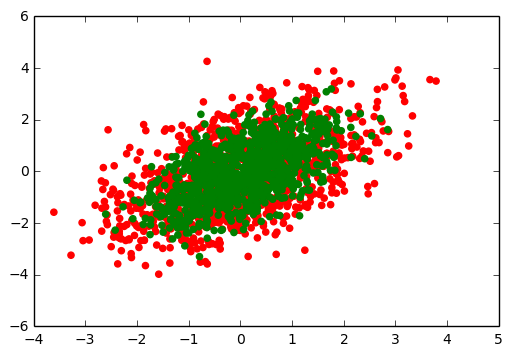

In [7]:
plt.scatter( X_pos[:, 0], X_pos[:, 1], color='red' )
plt.scatter( X_neg[:, 0], X_neg[:, 1], color='green' )
plt.show()

In [8]:
n_train = int( len(X)*0.5 )

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

Use a xgboost classifier:

In [9]:
model = xgboost.XGBClassifier(n_estimators = 500, min_child_weight = 10)
model.fit(X_train, y_train)
print 'Train accuracy : ', metrics.accuracy_score( model.predict(X_train), y_train )
print 'Test accuracy : ', metrics.accuracy_score( model.predict(X_test), y_test )

Train accuracy :  0.975
Test accuracy :  0.756


Do it again with the same number of sample for each features combination:

Indeed, the gain is always zero whatever the split !  
We can use a subsample value different from 1 to break the symmetry:

In [10]:
def convert_params(params):    
    converted = copy.deepcopy(params)
    converted['n_estimators'] = int(converted['n_estimators'])
    converted['max_depth'] = int(converted['max_depth'])
    converted['min_child_weight'] = int(converted['min_child_weight'])
    return converted

def score(params):  
    converted = convert_params( params )
    print "Training with params : "
    print converted
    
    model.set_params( **converted )
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'accuracy')
    score = scores.mean()
    print "Score :", score
  
    return {'loss': -score, 'status': STATUS_OK}

In [11]:
#Find best
space = {
             'n_estimators' : hp.quniform('n_estimators', 10, 2000, 1),
             'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 30, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 30, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.0, 1.0, 0.05),
             'silent' : 1
             }

#best = fmin(score, space, algo=tpe.suggest, max_evals=100)
best = {'learning_rate': 0.15000000000000002, 
        'min_child_weight': 1, 
        'n_estimators': 1996, 
        'subsample': 0.6000000000000001, 
        'max_depth': 19, 
        'gamma': 0.6000000000000001}

In [12]:
best = convert_params(best)
print best
model.set_params( **best )

model.fit(X_train, y_train)
print 'Train accuracy : ', metrics.accuracy_score( model.predict(X_train), y_train )
print 'Test accuracy : ', metrics.accuracy_score( model.predict(X_test), y_test )

model.set_params( **best )
scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'accuracy')
print 'Cross validation score on train :', scores.mean()

{'learning_rate': 0.15000000000000002, 'min_child_weight': 1, 'n_estimators': 1996, 'subsample': 0.6000000000000001, 'max_depth': 19, 'gamma': 0.6000000000000001}
Train accuracy :  1.0
Test accuracy :  0.794
Cross validation score on train : 0.782990874772


In [13]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.model_selection import cross_val_predict

class StackEnsemble(BaseEstimator, ClassifierMixin):
    
    #Init
    def __init__(self, clfs = None, stacker = None, clfs_cv = 5, use_features = False, preds = None):   
        if(clfs):
            self.clfs = clfs
        else:
            self.clfs = []
            
        self.stacker = stacker
        self.clfs_cv = clfs_cv
        self.use_features = use_features

        if( preds ):
            self.clfs_preds = preds
        elif( clfs ):
            self.clfs_preds = [None]*len(self.clfs)
        else:
            self.clfs_preds = []
        
    #Add clfs
    def add_clfs(self, clfs, preds = None ):#TODO deal with single element instead of lists
        self.clfs += clfs
        
        if(preds):
            self.clfs_preds += preds
        else:
            self.clfs_preds += [None]*len(clfs)
        
    #Predict
    def predict(self, X, y=None):
        #clfs predictions
        preds = np.zeros(( len(X), 0 ))
        for clf in self.clfs :
            preds = np.hstack(( preds, clf.predict_proba(X) ))
            
        #Add original features (or not)
        features = preds
        if( self.use_features ) : features = np.hstack( (X, features) )
        
        #Stacker predict
        return self.stacker.predict(features)
    
    #Fit clfs
    def fit_clfs(self, X, y=None, force_fit=False):
        for i, clf in enumerate(self.clfs) :
            #Only when forced or not fitted yet
            if( not force_fit and self.clfs_preds[i] != None ) : continue
            #clfs cv predictions
            self.clfs_preds[i] = cross_val_predict(clf, X, y, cv = 5, method='predict_proba')
            #clfs fit on whole sample
            clf.fit(X, y)
    
    
    #Fit
    def fit(self, X, y=None):
        #fit clfs
        self.fit_clfs(X, y)
            
        #Add original features (or not)
        features = np.hstack( tuple(self.clfs_preds) )
        if( self.use_features ) : features = np.hstack( (X, features) )
        
        #Stacker fit
        self.stacker.fit(features, y)
      
        return self
    
    
    #Score
    def score(self, X, y=None):
        return metrics.accuracy_score( self.predict(X), y )


In [15]:
from sklearn.linear_model import LogisticRegression
stack_model = StackEnsemble( [ xgboost.XGBClassifier(**best) ], LogisticRegression(fit_intercept = False, C = 1e10) )
stack_model.add_clfs( [xgboost.XGBClassifier(**best)] )
stack_model.add_clfs( [model], [model.predict_proba(X_train)] )

In [16]:
stack_model.fit(X_train, y_train)
print 'Train accuracy : ', metrics.accuracy_score( stack_model.predict(X_train), y_train )
print 'Test accuracy : ', metrics.accuracy_score( stack_model.predict(X_test), y_test )

Train accuracy :  1.0
Test accuracy :  0.796


In [93]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import ortho_group
from sklearn.base import TransformerMixin

class Rotation(TransformerMixin):
    def __init__(self, n_features):
        self.R = ortho_group.rvs(dim=n_features)
        self.Rp = np.linalg.inv( self.R )
        
    def transform(self, X):
        return np.array( [ self.R.dot( np.dot(x, self.Rp) ) for x in X ] )
    
    def fit(self, X = None, y = None, **fit_params):
        return self


models = []
for i in xrange(10):
    models.append( Pipeline([('rotation', Rotation(n_features) ), 
                             ('xgboost', xgboost.XGBClassifier(**best) ) ]) )


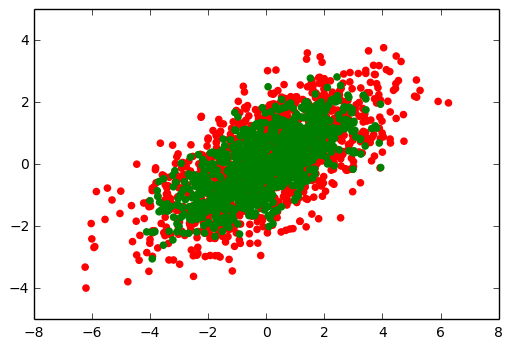

In [18]:
Xr = Rotation(n_features).transform(X)

X_pos = Xr[ y ]
X_neg = Xr[ ~y ]
plt.scatter( X_pos[:, 0], X_pos[:, 1], color='red' )
plt.scatter( X_neg[:, 0], X_neg[:, 1], color='green' )
plt.show()

In [19]:
stack_model = StackEnsemble( stacker = LogisticRegression(fit_intercept = False, C = 1e10) )

In [94]:
stack_model.add_clfs(models)

In [105]:
stack_model.fit(X_train, y_train)
print 'Train accuracy : ', metrics.accuracy_score( stack_model.predict(X_train), y_train )
print 'Test accuracy : ', metrics.accuracy_score( stack_model.predict(X_test), y_test )

Train accuracy :  1.0
Test accuracy :  0.847


In [96]:
from itertools import izip

for clf, pred in izip(stack_model.clfs, stack_model.clfs_preds):
    print metrics.accuracy_score( pred[:,0]<0.5, y_train ), metrics.accuracy_score( clf.predict(X_train), y_train ), metrics.accuracy_score( clf.predict(X_test), y_test )

0.779 1.0 0.791
0.772 1.0 0.803
0.766 1.0 0.788
0.774 1.0 0.809
0.773 1.0 0.803
0.785 1.0 0.795
0.797 1.0 0.791
0.79 1.0 0.806
0.78 1.0 0.813
0.759 1.0 0.799
0.775 1.0 0.797
0.781 1.0 0.795
0.754 1.0 0.81
0.774 1.0 0.794
0.799 1.0 0.79
0.784 1.0 0.794
0.757 1.0 0.804
0.774 1.0 0.797
0.76 1.0 0.788
0.788 1.0 0.81
0.75 1.0 0.791
0.77 1.0 0.796
0.793 1.0 0.802
0.785 1.0 0.789
0.762 1.0 0.798
0.776 1.0 0.789
0.767 1.0 0.813
0.796 1.0 0.79
0.774 1.0 0.795
0.78 1.0 0.783
0.781 1.0 0.79
0.776 1.0 0.81
0.771 1.0 0.797
0.756 1.0 0.801


In [97]:
print stack_model.stacker.coef_

[[-0.37751824  0.3752153   0.18142267 -0.18372564  0.09202362 -0.09432666
  -0.01785396  0.01555086  0.07352104 -0.0758242  -0.49179219  0.48948911
  -0.48714861  0.48484548 -0.41062701  0.40832385 -0.25934754  0.25704439
  -0.13834465  0.13604164  0.17300189 -0.17530491 -0.07702994  0.07472681
  -0.02166856  0.01936543 -0.14558014  0.14327708 -0.19037122  0.18806819
  -0.354458    0.35215495  0.14180879 -0.14411193  0.03566559 -0.03796857
   0.25431708 -0.25662014 -0.33632997  0.33402687  0.25515419 -0.25745731
   0.00511286 -0.007416   -0.31110175  0.30879875 -0.5870737   0.58477052
   0.11888159 -0.12118467 -0.16968885  0.16738576  0.1726335  -0.17493651
  -0.35370406  0.35140104 -0.47004484  0.46774182 -0.16654224  0.16423917
  -0.18985791  0.18755479 -0.1599475   0.15764452  0.09759513 -0.09989809
   0.04843286 -0.05073594]]


<matplotlib.colorbar.Colorbar instance at 0x7f21d9624950>

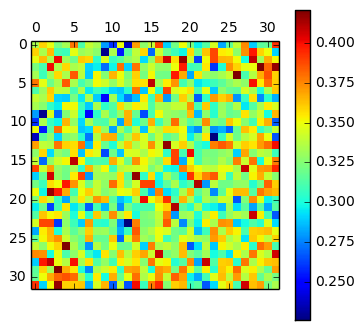

In [102]:
#TODO generalize multi label ?
corr = np.corrcoef( ( (np.array( stack_model.clfs_preds)[:,:,1] > 0.5) == y_train[None, :]) )
I = np.identity(len(stack_model.clfs_preds))
corr[ I == 1 ] = np.mean( corr[ I != 1 ] )
plt.matshow( corr )
plt.colorbar()

In [103]:
corr_nodiag = corr
corr_nodiag[ I == 1 ] = 0
m = np.mean( corr_nodiag, axis = 0 )
s = np.argsort(m)
print s
print m[s]

[21  7  9 11 12 23 10  6  0  8 14  1 22 20 26 24 25 15  3 17 27 18 19 31  5
  4 29 30 16 28  2 13]
[ 0.30090136  0.30490431  0.3072073   0.31142671  0.31163107  0.3135578
  0.31636213  0.31664282  0.31721282  0.31910754  0.31958039  0.32142277
  0.32295332  0.32342461  0.32359331  0.32396551  0.32873876  0.32924486
  0.32927412  0.32979456  0.3298127   0.32985939  0.33065581  0.33116912
  0.33185226  0.33294386  0.33385707  0.33406302  0.33533274  0.33631181
  0.33687563  0.34248655]


In [104]:
to_del = [28,2,13]

for td in to_del:
    del stack_model.clfs[td]
    del stack_model.clfs_preds[td]

<matplotlib.colorbar.Colorbar instance at 0x7f21e0060b48>

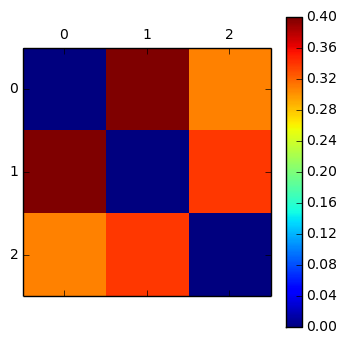

In [27]:
plt.matshow( corr[[1,2,6],:][:, [1,2, 6]] )
plt.colorbar()